<a href="https://colab.research.google.com/github/Sharminrahi/Deep-Learning/blob/main/Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Title: Assignment 3
### Name Sharmin Akhter
### ID: 201891112


# Question 1

The ultimate goal of this course is for you to be able to read scienti c papers on deep learning and being able to implement new methods being proposed in the literature yourself. Here we attempt to do this by implementing DenseNets from scratch, and test them for the CIFAR-10 Dataset.
Instructions:

1. Read the original DenseNet paper, which can be found here: https://arxiv.org/pdf/1608.06993.pdf.

2. There are a few custom building blocks that need to be implemented for a DenseNet model: The composition function, the actual DenseNet block, and the transition block. These can be de ned quite straighforwardly using Keras' functional API.

3. As DenseNets increase the number of feature maps over each DenseNet block, to make the model more compact, also a compression factor can be implemented for the transition block. Here, use a compression factor of   = 0:5.

4. Note that in the DenseNet paper, a second version is proposed that also includes Bottleneck layers. You can experiment with those as well, but they may not be needed for the relatively small CIFAR-10 Dataset.

5. As actual architecture, use a network that uses a total of 3 DenseNet blocks, with a growth rate of k = 12. Process the input images as described in the paper.

6. For the classi er part of the network (i.e. the part after the DenseNet blocks) use global averaging pooling, followed by the dense output layer (as in GoogLeNet).

7. There are two sets of experiments reported in the paper for CIFAR-10. One using data augmentation (as we have seen in class) but no dropout, and one using dropout but no data augmentation. Try out both, using a dropout rate of 20%.

8. Evaluate all your models on the test dataset. Which version gives the most accurate results? Does your DenseNet model beat the other models we have seen in class?

9. DSCI 6602 CIFAR-10 competition (optional!): Experiment with various hyper-
parameters (e.g. growth rate, number of layers, number of  lters, dropout rate, data augmentation, etc.) and report your best model results by sending me your accuracy score on the testing dataset (train your best model 10 times and send the mean accuracy over all 10 runs). I will keep track of this score and post it on Brightspace.

# Load Libraries

In [1]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Using tensor flow Keras Functional API

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Step 1
Load the CIFAR-10 dataset

In [3]:
cifar_10 = tf.keras.datasets.cifar10
cifar_10

<module 'keras.api._v2.keras.datasets.cifar10' from '/usr/local/lib/python3.9/dist-packages/keras/api/_v2/keras/datasets/cifar10/__init__.py'>

# Step 2
Building traning/testing pipelines

In [4]:
(X_train, Y_train), (X_test, Y_test) = cifar_10.load_data()

170498071/170498071 [==============================] - 18s 0us/step


In [5]:
# summarize loaded dataset
print('Train: X=%s, y=%s' % (X_train.shape, Y_train.shape))
print('Test: X=%s, y=%s' % (X_test.shape, Y_test.shape))

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


We can see that there are 50,000 examples in the training dataset and 10,000 in the test dataset and that images are indeed square with 32×32 pixels and color, with three channels i.e. images are color images. As well as it is also visible that there is only a single label assigned with each image.



# Step 3: Process the Data
We need to process the data in order to send it to the network which includes:

1. Reduce the pixel values (range between 0 and 1)
2. We can do this simply dividing all pixel values by 255
3. We can also do flatten(rearrange them in form of row)

In [6]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize to range from 0 to 1

In [7]:
X_train = X_train/255.0
X_test = X_test/255.0

In [8]:
X_train

array([[[[0.23137255, 0.24313726, 0.24705882],
         [0.16862746, 0.18039216, 0.1764706 ],
         [0.19607843, 0.1882353 , 0.16862746],
         ...,
         [0.61960787, 0.5176471 , 0.42352942],
         [0.59607846, 0.49019608, 0.4       ],
         [0.5803922 , 0.4862745 , 0.40392157]],

        [[0.0627451 , 0.07843138, 0.07843138],
         [0.        , 0.        , 0.        ],
         [0.07058824, 0.03137255, 0.        ],
         ...,
         [0.48235294, 0.34509805, 0.21568628],
         [0.46666667, 0.3254902 , 0.19607843],
         [0.47843137, 0.34117648, 0.22352941]],

        [[0.09803922, 0.09411765, 0.08235294],
         [0.0627451 , 0.02745098, 0.        ],
         [0.19215687, 0.10588235, 0.03137255],
         ...,
         [0.4627451 , 0.32941177, 0.19607843],
         [0.47058824, 0.32941177, 0.19607843],
         [0.42745098, 0.28627452, 0.16470589]],

        ...,

        [[0.8156863 , 0.6666667 , 0.3764706 ],
         [0.7882353 , 0.6       , 0.13333334]

In [9]:
X_test

array([[[[0.61960787, 0.4392157 , 0.19215687],
         [0.62352943, 0.43529412, 0.18431373],
         [0.64705884, 0.45490196, 0.2       ],
         ...,
         [0.5372549 , 0.37254903, 0.14117648],
         [0.49411765, 0.35686275, 0.14117648],
         [0.45490196, 0.33333334, 0.12941177]],

        [[0.59607846, 0.4392157 , 0.2       ],
         [0.5921569 , 0.43137255, 0.15686275],
         [0.62352943, 0.44705883, 0.1764706 ],
         ...,
         [0.53333336, 0.37254903, 0.12156863],
         [0.49019608, 0.35686275, 0.1254902 ],
         [0.46666667, 0.34509805, 0.13333334]],

        [[0.5921569 , 0.43137255, 0.18431373],
         [0.5921569 , 0.42745098, 0.12941177],
         [0.61960787, 0.43529412, 0.14117648],
         ...,
         [0.54509807, 0.38431373, 0.13333334],
         [0.50980395, 0.37254903, 0.13333334],
         [0.47058824, 0.34901962, 0.12941177]],

        ...,

        [[0.26666668, 0.4862745 , 0.69411767],
         [0.16470589, 0.39215687, 0.5803922 ]

# Flatten the image

In [10]:
Y_train = Y_train.flatten()
Y_test = Y_test.flatten()
     

In [11]:
Y_train

array([6, 9, 9, ..., 9, 1, 1], dtype=uint8)

In [12]:
Y_test

array([3, 8, 8, ..., 5, 1, 7], dtype=uint8)

# Plot First few images

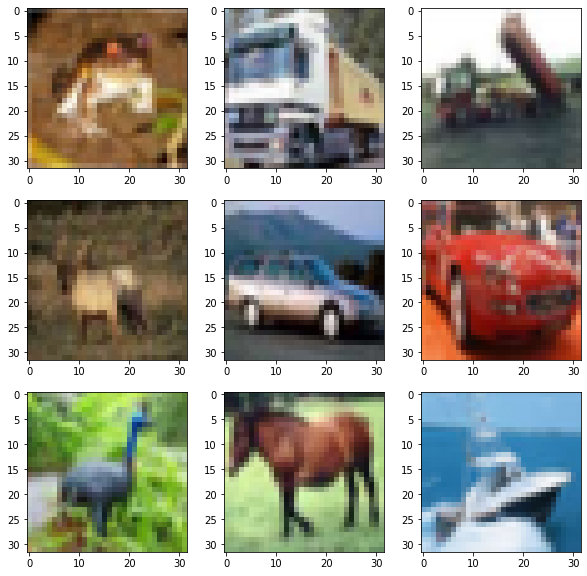

In [13]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,10))

for i in range(9):
    # define subplot
    plt.subplot(3, 3, i+1)
    # plot raw pixel data
    plt.imshow(X_train[i])

# show the figure
plt.show()


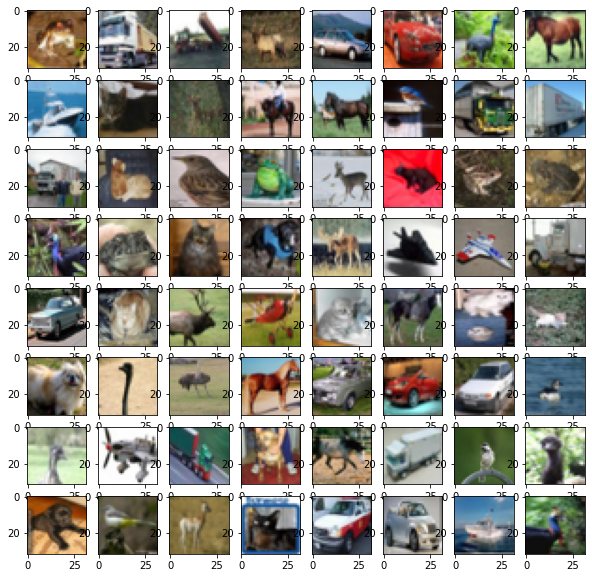

In [14]:
# visualize data by plotting images
fig, ax = plt.subplots(8, 8, figsize=(10,10))
k = 0
 
for i in range(8):
    for j in range(8):
        ax[i][j].imshow(X_train[k], aspect='auto')
        k += 1
 
plt.show()

# Question 1 (part 2)

There are a few custom building blocks that need to be implemented for a DenseNet model: The composition function, the actual DenseNet block, and the transition block. These can be de ned quite straighforwardly using Keras' functional API.

# Define Composition Function


In [15]:
#define composition function
def composite_function(inp, filters, kernel_size, dropout = 0.0):
  b = tf.keras.layers.BatchNormalization()(inp)
  b = tf.keras.layers.Activation("relu")(b)
  b = tf.keras.layers.Conv2D(filters, kernel_size, padding = "same")(b)
  out = tf.keras.layers.Dropout(dropout)(b)
  return out

# Define Main DenseNet block

In [16]:
# Define the main DenseNet block
def densenet_block(inp, num_layers, filters, dropout = 0.0, bottleneck = False):
  for _ in range(num_layers):
    if bottleneck:
      b = composite_function(inp, 4*filters, (1,1), dropout = dropout)
    else:
      b = inp
    b = composite_function(b, filters, (3,3), dropout = dropout)
    inp = tf.keras.layers.Concatenate(axis = -1)([b, inp])
  return inp  

In [17]:
# Define the main DenseNet block
def densenet_block(inp, num_layers, filters, dropout=0.0, bottleneck=False):
  for _ in range(num_layers):
    if bottleneck:
      b = composite_function(inp, 4*filters, (1,1), dropout=dropout)
    else:
      b = inp
    b = composite_function(b, filters, (3,3), dropout=dropout)
    inp = tf.keras.layers.Concatenate(axis=-1)([b, inp])
  return inp 

# Question 1(3)
As DenseNets increase the number of feature maps over each DenseNet block, to make the model more compact, also a compression factor can be implemented for the transition block. Here, use a compression factor of   = 0:5.

# Define Transition Layer with compression 0.5

In [18]:
# Define the transition layer
def transition_layer(inp, compression = 0.5, dropout = 0.0):
  filters = tf.keras.backend.int_shape(inp)[-1]
  filters = int(filters * compression)
  b = composite_function(inp, filters, (1,1), dropout=dropout)
  out = tf.keras.layers.AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='same')(b)
  return out

# Question 1(5)
As actual architecture, use a network that uses a total of 3 DenseNet blocks, with a growth rate of k = 12. Process the input images as described in the paper.

# Question 1(6)

For the classifier part of the network (i.e. the part after the DenseNet blocks) use global averaging pooling, followed by the dense output layer (as in GoogLeNet).

#Without Data Augmentation but with dropout

In [19]:
# Define DenseNet model
input_shape = (32,32,3)
num_classes = 10
block_config = (6,12,24)
growth_rate = 12
compression = 0.5
dropout = 0.2
bottleneck = True

inp = tf.keras.Input(shape=input_shape)
x = inp

# Initial convolution layer
x = tf.keras.layers.Conv2D(2*growth_rate, (7,7), strides=(2,2), padding = 'same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size = (3,3), strides=(2,2), padding = 'same')(x)

# Dense blocks
for i, num_layers in enumerate(block_config):
    x = densenet_block(x, num_layers, growth_rate, dropout = dropout, bottleneck = bottleneck)
    if i != len(block_config) - 1:
        x = transition_layer(x, compression=compression, dropout=dropout)

# Final layers
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x) #globalaverage pooling
x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=inp, outputs=x)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 24)   3552        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 24)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 16, 16, 24)   0           ['batch_normalization[0][0]']

# Compile the model

In [20]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Train the model

In [21]:
# train the model with the images
hist = model.fit(X_train, Y_train, epochs = 20, batch_size = 32, validation_split = 0.1,
          callbacks = [tf.keras.callbacks.EarlyStopping(patience = 5)])

Epoch 1/20
1407/1407 [==============================] - 182s 78ms/step - loss: 1.6205 - accuracy: 0.4038 - val_loss: 1.6521 - val_accuracy: 0.4046
Epoch 2/20
1407/1407 [==============================] - 102s 73ms/step - loss: 1.3044 - accuracy: 0.5291 - val_loss: 1.9395 - val_accuracy: 0.4068
Epoch 3/20
1407/1407 [==============================] - 104s 74ms/step - loss: 1.1457 - accuracy: 0.5884 - val_loss: 1.8265 - val_accuracy: 0.4486
Epoch 4/20
1407/1407 [==============================] - 104s 74ms/step - loss: 1.0334 - accuracy: 0.6305 - val_loss: 1.2340 - val_accuracy: 0.5782
Epoch 5/20
1407/1407 [==============================] - 104s 74ms/step - loss: 0.9635 - accuracy: 0.6569 - val_loss: 1.3457 - val_accuracy: 0.5926
Epoch 6/20
1407/1407 [==============================] - 103s 73ms/step - loss: 0.9079 - accuracy: 0.6796 - val_loss: 1.2330 - val_accuracy: 0.5960
Epoch 7/20
1407/1407 [==============================] - 104s 74ms/step - loss: 0.8652 - accuracy: 0.6927 - val_loss: 1

# Plot loss function

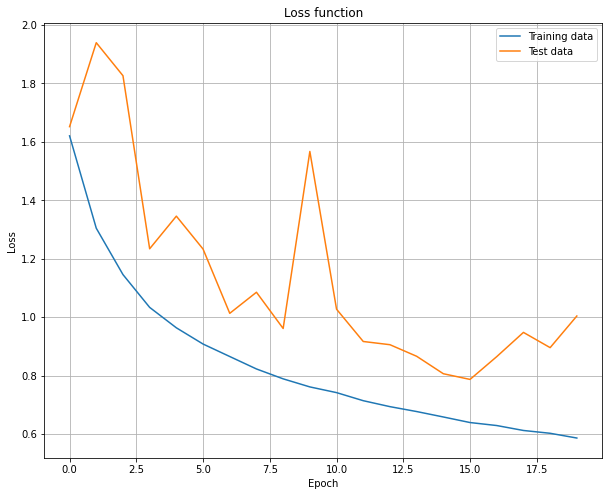

In [22]:
fig = plt.figure(figsize=(10,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss function')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Training data', 'Test data'])
plt.show()


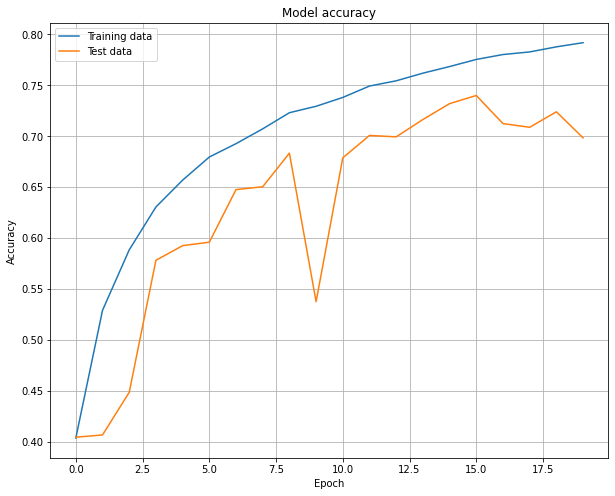

In [23]:
fig = plt.figure(figsize=(10,8))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Training data', 'Test data'])

Now evaluate the model on the test dataset

In [24]:
loss_accuracy = model.evaluate(X_test, Y_test, verbose = 0)

print("Test Loss: {}".format(loss_accuracy[0]))
print("Test Accuracy: {}".format(loss_accuracy[1]))

Test Loss: 1.0271680355072021
Test Accuracy: 0.6852999925613403


# Data Augmentation with no dropout

In [25]:
# This is the data augmentation part (Simply add random flips and rotation)
b = tf.keras.layers.RandomFlip('horizontal')(inp)
b = tf.keras.layers.RandomRotation(0.2)(b)


In [26]:
# Define DenseNet model
input_shape = (32,32,3)
num_classes = 10
block_config = (6,12,24)
growth_rate = 12
compression = 0.5
dropout = 0.0
bottleneck = True

inp = tf.keras.Input(shape=input_shape)
x = inp

# This is the data augmentation part (Simply add random flips and rotation)
b = tf.keras.layers.RandomFlip('horizontal')(inp)
b = tf.keras.layers.RandomRotation(0.2)(b)

# Initial convolution layer
x = tf.keras.layers.Conv2D(2*growth_rate, (7,7), strides=(2,2), padding = 'same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size = (3,3), strides=(2,2), padding = 'same')(x)

# Dense blocks
for i, num_layers in enumerate(block_config):
    x = densenet_block(x, num_layers, growth_rate, dropout = dropout, bottleneck = bottleneck)
    if i != len(block_config) - 1:
        x = transition_layer(x, compression=compression, dropout=dropout)

# Final layers
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x) #globalaverage pooling
x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model1 = tf.keras.Model(inputs=inp, outputs=x)

model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_87 (Conv2D)             (None, 16, 16, 24)   3552        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_88 (BatchN  (None, 16, 16, 24)  96          ['conv2d_87[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_88 (Activation)     (None, 16, 16, 24)   0           ['batch_normalization_88[0]

# Compile the model

In [27]:
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model

In [30]:
# train the model with the images
hist1 = model1.fit(X_train, Y_train, epochs = 20, batch_size = 32, validation_split = 0.1,
          callbacks = [tf.keras.callbacks.EarlyStopping(patience = 5)])

Epoch 1/20
1407/1407 [==============================] - 104s 74ms/step - loss: 0.2610 - accuracy: 0.9069 - val_loss: 0.9260 - val_accuracy: 0.7500
Epoch 2/20
1407/1407 [==============================] - 101s 72ms/step - loss: 0.2381 - accuracy: 0.9141 - val_loss: 1.0871 - val_accuracy: 0.7156
Epoch 3/20
1407/1407 [==============================] - 100s 71ms/step - loss: 0.2187 - accuracy: 0.9232 - val_loss: 1.0972 - val_accuracy: 0.7180
Epoch 4/20
1407/1407 [==============================] - 100s 71ms/step - loss: 0.2014 - accuracy: 0.9286 - val_loss: 1.2397 - val_accuracy: 0.7046
Epoch 5/20
1407/1407 [==============================] - 102s 73ms/step - loss: 0.1878 - accuracy: 0.9328 - val_loss: 1.0864 - val_accuracy: 0.7326
Epoch 6/20
1407/1407 [==============================] - 101s 72ms/step - loss: 0.1691 - accuracy: 0.9399 - val_loss: 1.3091 - val_accuracy: 0.7032


# Plot

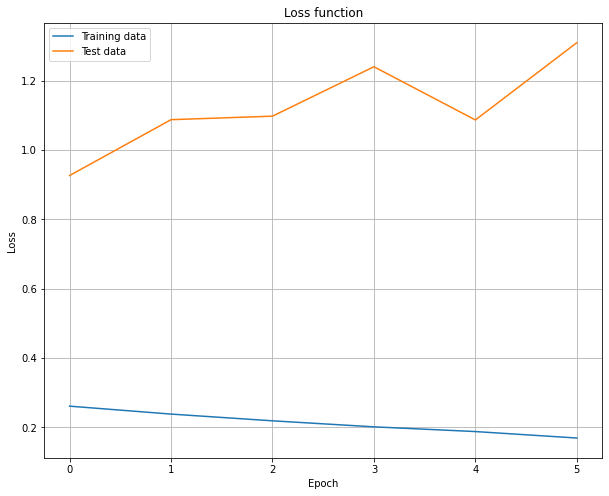

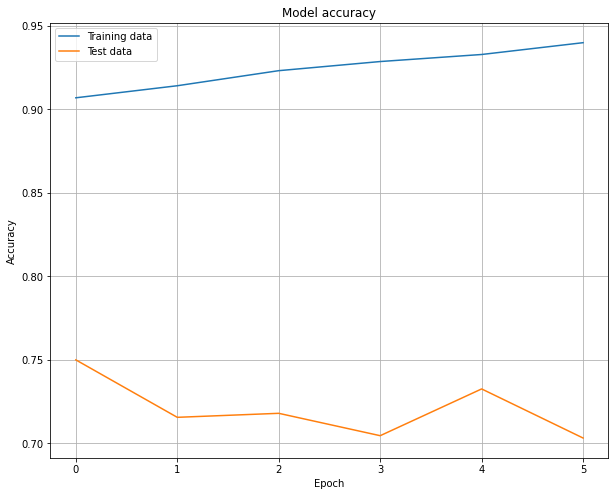

In [33]:
fig = plt.figure(figsize=(10,8))
plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.title('Loss function')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Training data', 'Test data'])
plt.show()

fig = plt.figure(figsize=(10,8))
plt.plot(hist1.history['accuracy'])
plt.plot(hist1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Training data', 'Test data'])

# evaluate the model

In [35]:
loss_accuracy = model1.evaluate(X_test, Y_test, verbose = 0)

print("Test Loss: {}".format(loss_accuracy[0]))
print("Test Accuracy: {}".format(loss_accuracy[1]))

Test Loss: 1.3073400259017944
Test Accuracy: 0.6913999915122986
